# Vowel Speech Recognition Example
K = 11 classes and p = 10 predictors. The classes correspond to 11 vowel sounds, each contained in 11 diﬀerent words. Here are the words, preceded by the symbols that represent them:

|Vowel|Word|Vowel|Word |Vowel|Word|Vowel|Word |
|-----|----|-----|-----|-----|----|-----|-----|
|i:   |heed|O    |hod  |I    |hid |C    |hoard|
|E    |head|U    |hood |A    |had |u:   |who'd|
|a:   |hard|3:   |heard|Y    |hud |

Each of eight speakers spoke each word six times in the training set, and likewise seven speakers in the test set. The ten predictors are derived from the digitized speech in a rather complicated way, but standard in the speech recognition world. There are thus 528 training observations, and 462 test observations. (PAGE 442-443)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
import pandas as pd

np.warnings.filterwarnings('ignore')
%matplotlib inline

# set common plots properties and define commonly used colors
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
BLUE, ORANGE, GRAY1, GRAY4 = '#57B5E8', '#E69E00', '#231F20', '#646369'

## Load and Prepare Data

In [2]:
# load training and test data set from the file
df = pd.read_csv("../data/Vowel.txt")
# rename classes to be in range 0-10
df.y = df.y - 1
df.head()

,row.names,y,x.1,x.2,x.3,x.4,x.5,x.6,x.7,x.8,x.9,x.10,is_train
0,1,0,-3.639,0.418,-0.670,1.779,-0.168,1.627,-0.388,0.529,-0.874,-0.814,1
1,2,1,-3.327,0.496,-0.694,1.365,-0.265,1.933,-0.363,0.510,-0.621,-0.488,1
2,3,2,-2.120,0.894,-1.576,0.147,-0.707,1.559,-0.579,0.676,-0.809,-0.049,1
3,4,3,-2.287,1.809,-1.498,1.012,-1.053,1.060,-0.567,0.235,-0.091,-0.795,1
4,5,4,-2.598,1.938,-0.846,1.062,-1.633,0.764,0.394,-0.150,0.277,-0.396,1


In [3]:
features = [f'x.{i+1}' for i in range(10)]

# split data to training/test based on _is_train flag
df_train, df_test = df[df.is_train == 1], df[df.is_train == 0]
X_train, y_train = df_train[features].values, df_train.y.values
X_test, y_test = df_test[features].values, df_test.y.values

<h2>Linear Regression of an Indicator Matrix</h2>

In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

In [5]:
# PAGE 103. Here each of the response categories are coded via an indicator
#           variable.
Y_train_one_hot = OneHotEncoder(
    categories='auto'
).fit_transform(np.atleast_2d(y_train).T).toarray()

# PAGE 103. We fit a linear regression model to each of the columns of Y
#           simultaneously
reg = LinearRegression().fit(X_train, Y_train_one_hot)

# PAGE 103. identify the largest component and classify accordingly;
y_train_hat = np.argmax(reg.predict(X_train), axis=1)
y_test_hat = np.argmax(reg.predict(X_test), axis=1)

# PAGE 106. There are K = 11 classes in p = 10 dimensions. This is a difficult
#           classification problem, and the best methods achieve around 40%
#           errors on the test data. The main point here is summarized in
#           Table 4.1; linear regression has an error rate of 67%, while a
#           close relative, linear discriminant analysis, has an error rate of
#           56%. It seems that masking has hurn in this case. While all the
#           other methods in this chapter are based on linear functions of x as
#           well, they use them in such a way that avoids this masking problem.
lin_train_error = 1 - accuracy_score(y_train, y_train_hat)
lin_test_error = 1 - accuracy_score(y_test, y_test_hat)
print(f'Linear regression {lin_train_error:.2f} {lin_test_error:.2f}')

Linear regression 0.48 0.67


<h2>Linear Discriminant Analysis</h2>

In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [7]:
# PAGE 108. Linear discriminant analysis (LDA) arises in the special case when
#           we assume that the classes have a common covariance matrix Σk=Σ∀k.
lda = LinearDiscriminantAnalysis(n_components=2).fit(X_train, y_train)
lda_train_error = 1 - accuracy_score(y_train, lda.predict(X_train))
lda_test_error = 1 - accuracy_score(y_test, lda.predict(X_test))
print(f'LDA {lda_train_error:.2f} {lda_test_error:.2f}')

LDA 0.32 0.56


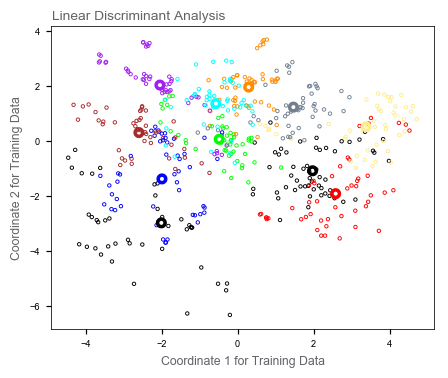

In [8]:
# PAGE 107. Figure 4.4. A two-dimensional plot of the vowel training data.
#           There are eleven classes with X in R^10, and this is the best view
#           in terms of LDA model (Section 4.3.3). The heavy circles are the
#           projected means vectors for each classes. The class overlap is
#           considerable.
X_r = lda.transform(X_train)
means = lda.transform(lda.means_)

# define colors for classes
colors = np.array([
    '#000000', '#0000FF', '#A52A2A', '#A020F0', '#FF8C00', '#00FFFF',
    '#708090', '#FFEC8B', '#000000', '#FF0000', '#00FF00'])
fig, ax = plt.subplots(figsize=(4.5, 3.65), dpi=110)
ax.scatter(X_r[:, 0], X_r[:, 1], facecolors='none',
           edgecolors=colors[y_train], s=5, linewidth=0.6)
ax.scatter(means[:, 0], means[:, 1], facecolors='none', edgecolors=colors,
           s=5, linewidth=5)
for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(6)
ax.text(-4.89, 4.4, 'Linear Discriminant Analysis', color=GRAY4, fontsize=9)
ax.set_xlabel('Coordinate 1 for Training Data', color=GRAY4, fontsize=8)
_ = ax.set_ylabel('Coordinate 2 for Training Data', color=GRAY4, fontsize=8)

<h2>Quadratic Discriminant Analysis</h2>

In [9]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [10]:
# PAGE 110. Getting back to the general discriminant problem (4.8), if the Σk
#           are not assumed to be equal, then the convenient cancellations in
#           (4.9) do not occur; in particular the pieces quadratic in x remain.
#           We then get quadratic discriminant functions (QDA).
qda = QuadraticDiscriminantAnalysis().fit(X_train, y_train)
qda_train_error = 1 - accuracy_score(y_train, qda.predict(X_train))
qda_test_error = 1 - accuracy_score(y_test, qda.predict(X_test))
print(f'QDA {qda_train_error:.2f} {qda_test_error:.2f}')

QDA 0.01 0.53


<h2>Regularized Discriminant Analysis</h2>
NOTE: The sklearn uses not such a regularization as in the book. The result is similar in shape, but the values deffer significantly.

In [11]:
# PAGE 112. Friedman (1989) proposed a compromise between LDA and QDA, which
#           allows one to shrink the separate covariances of QDA toward a
#           common covariance as in LDA. These methods are very similar in
#           ﬂavor to ridge regression. The regularized covariance matrices have
#           the form (4.13)
alpha = np.linspace(0, 1, 51)
rda_train_error = []
rda_test_error = []

# calculate training-test errors for each alpha value
for i in range(51):
    rda = QuadraticDiscriminantAnalysis(
        reg_param=1-alpha[i]
    ).fit(X_train, y_train)
    rda_train_error.append(1 - accuracy_score(y_train, rda.predict(X_train)))
    rda_test_error.append(1 - accuracy_score(y_test, rda.predict(X_test)))

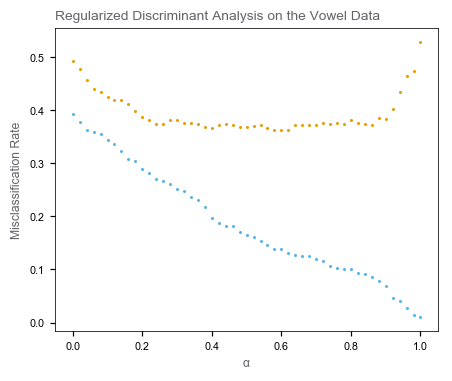

In [12]:
# PAGE 112. FIGURE 4.7. Test and training errors for the vowel data, using
#           regularized discriminant analysis with a series of values of
#           α ∈ [0,1]. The optimum for the test data occurs around α = 0.9,
#           close to quadratic discriminant analysis.
fig, ax = plt.subplots(figsize=(4.5, 3.65), dpi=110)
ax.scatter(alpha, rda_train_error, c=BLUE, s=1)
ax.scatter(alpha, rda_test_error, c=ORANGE, s=1)
ax.text(-0.05, 0.57, 'Regularized Discriminant Analysis on the Vowel Data',
        color=GRAY4, fontsize=9)
ax.set_xlabel('α', color=GRAY4, fontsize=8)
ax.set_ylabel('Misclassification Rate', color=GRAY4, fontsize=8)
for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(7)

<h2>Reduced-Rank Linear Discriminant Analysis</h2>

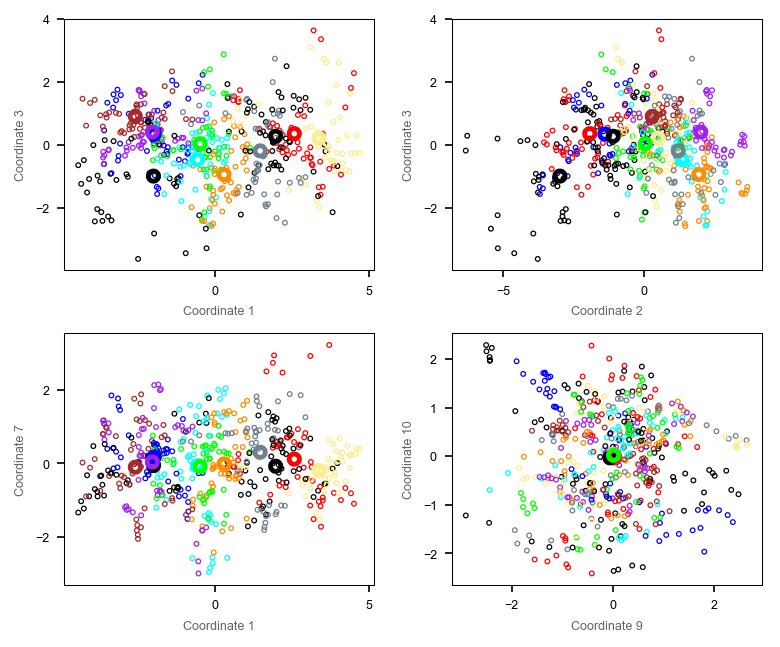

In [13]:
# PAGE 113. So far we have discussed LDA as a restricted Gaussian classiﬁer.
#           Part of its popularity is due to an additional restriction that
#           allows us to view informative low-dimensional projections of the
#           data. The K centroids in p-dimensional input space lie in an aﬃne
#           subspace of dimension ≤ K−1, and if p is much larger than K, this
#           will be a considerable drop in dimension.
lda = LinearDiscriminantAnalysis(n_components=10).fit(X_train, y_train)
X_r = lda.transform(X_train)
means = lda.transform(lda.means_)


# plot points and centroids projection on i-th x j-th canonical variates
def plot_projection(ax, i, j):
    ax.scatter(X_r[:, i], X_r[:, j], facecolors='none',
               edgecolors=colors[y_train], s=5, linewidth=0.6)
    ax.scatter(means[:, i], means[:, j], facecolors='none', edgecolors=colors,
               s=5, linewidth=5)
    for t in ax.get_yticklabels() + ax.get_xticklabels():
        t.set_fontsize(6)
    ax.set_xlabel(f'Coordinate {i+1}', color=GRAY4, fontsize=6)
    ax.set_ylabel(f'Coordinate {j+1}', color=GRAY4, fontsize=6)

# PAGE 115. FIGURE 4.8. Four projections onto pairs of canonical variates.
#           Notice that as the rank of the canonical variates increases, the
#           centroids become less spread out. In the lower right panel they
#           appear to be superimposed, and the classes most confused.
fig, axarr = plt.subplots(2, 2, figsize=(6, 5), dpi=150)
plt.subplots_adjust(wspace=0.25, hspace=0.25)
plot_projection(axarr[0, 0], 0, 2)
plot_projection(axarr[0, 1], 1, 2)
plot_projection(axarr[1, 0], 0, 6)
plot_projection(axarr[1, 1], 8, 9)

In [14]:
# PAGE 117. There are 11 classes and 10 variables, and hence 10 possible
#           dimensions for the classiﬁer. We can compute the training and test
#           error in each of these hierarchical subspaces; Figure 4.10 shows
#           the results. Figure 4.11 shows the decision boundaries for the
#           classiﬁer based on the two-dimensional LDA solution.
X_r_test = lda.transform(X_test)
dimension = list(range(1, 11))
rda_train_error = []
rda_test_error = []
for i in range(1, 11):
    rda = LinearDiscriminantAnalysis().fit(X_r[:, :i], y_train)
    rda_train_error.append(
        1 - accuracy_score(y_train, rda.predict(X_r[:, :i])))
    rda_test_error.append(
        1 - accuracy_score(y_test, rda.predict(X_r_test[:, :i])))

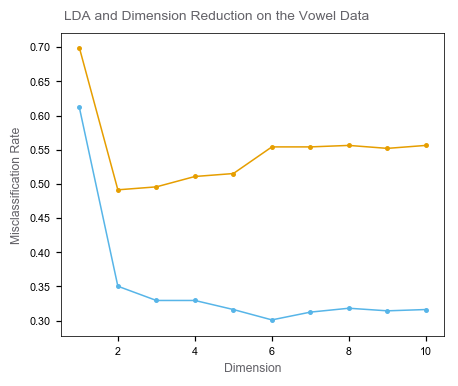

In [15]:
# PAGE 117. FIGURE 4.10. Training and test error rates for the vowel data, as a
#           function of the dimension of the discriminant subspace. In this
#           case the best error rate is for dimension 2. Figure 4.11 shows the
#           decision boundaries in this space.
fig, ax = plt.subplots(figsize=(4.5, 3.65), dpi=110)
ax.scatter(dimension, rda_train_error, c=BLUE, s=5)
ax.scatter(dimension, rda_test_error, c=ORANGE, s=5)
ax.plot(dimension, rda_train_error, c=BLUE, linewidth=1)
ax.plot(dimension, rda_test_error, c=ORANGE, linewidth=1)
ax.text(0.6, 0.74, 'LDA and Dimension Reduction on the Vowel Data',
        color=GRAY4, fontsize=9)
ax.set_xlabel('Dimension', color=GRAY4, fontsize=8)
ax.set_ylabel('Misclassification Rate', color=GRAY4, fontsize=8)
for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(7)

In [16]:
# PAGE 110. For this ﬁgure and many similar ﬁgures in the book we compute the
#           decision boundaries by an exhaustive contouring method. We compute
#           the decision rule on a ﬁne lattice of points, and then use
#           contouring algorithms to compute the boundaries.
rda = LinearDiscriminantAnalysis().fit(X_r[:, :2], y_train)
grid = 2000
x1_vals = np.linspace(-4.5, 5, grid)
x2_vals = np.linspace(-6.5, 4.5, grid)
X = np.transpose([np.tile(x1_vals, grid), np.repeat(x2_vals, grid)])
y = rda.predict(X)
X0, X1 = X[:, 0].reshape(grid, grid), X[:, 1].reshape(grid, grid)
Y = y.reshape(grid, grid)

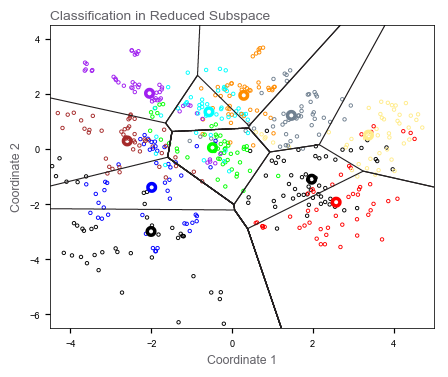

In [17]:
# PAGE 118. FIGURE 4.11. Decision boundaries for the vowel training data, in
#           the two-dimensional subspace spanned by the ﬁrst two canonical
#           variates. Note that in any higher-dimensional subspace, the
#           decision boundaries are higher-dimensional aﬃne planes, and could
#           not be represented as lines.
fig, ax = plt.subplots(figsize=(4.5, 3.65), dpi=110)
ax.scatter(X_r[:, 0], X_r[:, 1], facecolors='none',
            edgecolors=colors[y_train], s=5, linewidth=0.6)
ax.scatter(means[:, 0], means[:, 1], facecolors='none', edgecolors=colors,
            s=5, linewidth=5)
for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(6)
ax.text(-4.5, 4.7, 'Classification in Reduced Subspace', color=GRAY4,
        fontsize=9)
ax.set_xlabel('Coordinate 1', color=GRAY4, fontsize=8)
ax.set_ylabel('Coordinate 2', color=GRAY4, fontsize=8)
_ = ax.contour(X0, X1, Y, np.linspace(0, 9, 10)+0.5, colors=GRAY1,
               linewidths=[0.7]*10)

<h2>Logistic Regression</h2>

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [19]:
# PAGE 119. The logistic regression model arises from the desire to model the
#           posterior probabilities of the K classes via linear functions in x,
#           while at the same time ensuring that they sum to one and remain in
#           [0,1]. The model has the form (4.17).
lr = LogisticRegression(C=11, multi_class='multinomial', solver='lbfgs',
                        max_iter=1000000)
lr.fit(X_train, y_train)
lr_train_error = 1 - accuracy_score(y_train, lr.predict(X_train))
lr_test_error = 1 - accuracy_score(y_test, lr.predict(X_test))
print(f'Logistic Regression {lr_train_error:.2f} {lr_test_error:.2f}')

Logistic Regression 0.23 0.51


## Linear Models Summary

In [20]:
# PAGE 107. TABLE 4.1. Training and test error rates using a variety of linear
#           techniques on the vowel data. There are eleven classes in ten
#           dimensions, of which three account for 90% of the variance (via a
#           principal component analysis). We see that linear regression is
#           hurt by masking, increasing the test and training error by over
#           10%.
models = ['Linear regression', 'Linear discriminant analysis',
          'Quadratic discriminant analysis', 'Logistic regression']
train_errors = [lin_train_error, lda_train_error, qda_train_error,
                lr_train_error]
test_errors = [lin_test_error, lda_test_error, qda_test_error, lr_test_error]
print('                      Technique     Error Rates')
print('                                  Traing     Test')
for model, train_error, test_error in zip(models, train_errors, test_errors):
    print(f'{model:>31}   {train_error:.2f} {test_error:>10.2f}')

                      Technique     Error Rates
                                  Traing     Test
              Linear regression   0.48       0.67
   Linear discriminant analysis   0.32       0.56
Quadratic discriminant analysis   0.01       0.53
            Logistic regression   0.23       0.51


## FDA/MARS
I have not found the flexible discriminant analysis implementation for Python. Implemented it myself. I didn't find the generalized additive model (BRUTO in R) implementation for Python, which allows multiresponse. Thus, it only works for MARS model. The result is close to the values from the book, but slightly worse. Maybe I made some mistakes. More research and testing is needed. The approch is explained here https://www.researchgate.net/publication/2889611_Flexible_Discriminant_Analysis_by_Optimal_Scoring.

In [21]:
from pyearth import Earth

In [22]:
# let's implement our flexible discriminant classifier
class FlexibleDiscriminantAnalysis():
    def __init__(self, model, n_components=None):
        self.model = model
        self.n_components = n_components

    def fit(self, X, y):
        _, counts_elements = np.unique(y, return_counts=True)
        priors = counts_elements/y.shape[0]
        # PAGE 440. We create an N × K indicator response matrix Y
        Y = OneHotEncoder(
            categories='auto'
        ).fit_transform(np.atleast_2d(y).T).toarray()

        # PAGE 441. Multivariate nonparametric regression. Fit a multiresponse,
        #           adaptive nonparametric regression of Y on X
        self.model.fit(X, Y)

        # PAGE 441. Optimal scores. Compute the eigen-decomposition of
        #           Y.T @ Y_hat
        X_exp = self.model.transform(X)
        self.B = self.model.coef_.T
        evals, evecs = np.linalg.eig(Y.T @ (X_exp @ self.B))
        evals_ord = np.argsort(evals)[::-1]
        evals = evals[evals_ord]
        evecs = evecs[:, evals_ord]
        O = evecs
        O /= np.sqrt(np.diagonal(O.T @ np.diag(priors) @ O))

        # PAGE 441. Update the model from step 1 using the optimal scores.
        self.B = self.B @ O
        R = self.transform(X)
        self.lda = LinearDiscriminantAnalysis().fit(R, y)
        return self

    def transform(self, X):
        X_exp = self.model.transform(X)
        R = (self.B.T @ X_exp.T).T
        if self.n_components is None:
            return R
        return R[:, :self.n_components]

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)

    def predict(self, X):
        R = self.transform(X)
        return self.lda.predict(R)

In [23]:
fda1 = FlexibleDiscriminantAnalysis(
    Earth(max_terms=47, max_degree=1, enable_pruning=False),
    n_components=4
).fit(X_train, y_train)
fda1_train_er = 1 - accuracy_score(y_train, fda1.predict(X_train))
fda1_test_er = 1 - accuracy_score(y_test, fda1.predict(X_test))

In [24]:
fda2 = FlexibleDiscriminantAnalysis(
    Earth(max_terms=44, max_degree=2, enable_pruning=False),
    n_components=7
).fit(X_train, y_train)
fda2_train_er = 1 - accuracy_score(y_train, fda2.predict(X_train))
fda2_test_er = 1 - accuracy_score(y_test, fda2.predict(X_test))

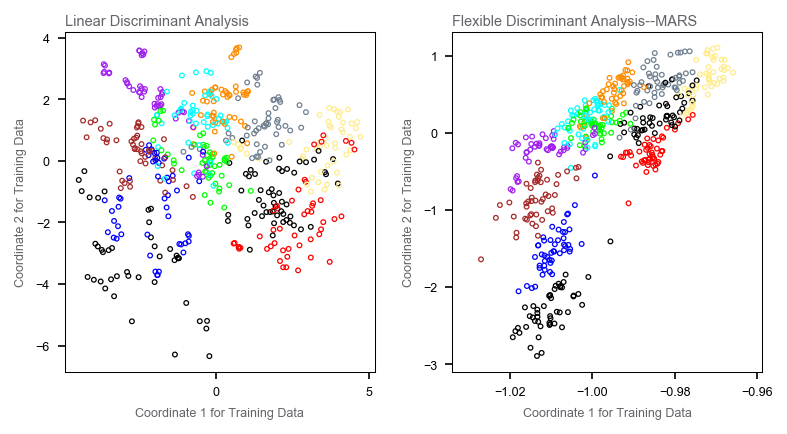

In [25]:
# PAGE 443. FIGURE 12.10. The left plot shows the first two LDA canonical variates for
#           the vowel training data. The right plot shows the corresponding projection when
#           FDA/BRUTO is used to fit the model; plotted are the fitted regression functions
#           ηˆ1(xi) and ηˆ2(xi). Notice the improved separation. The colors represent the eleven
#           different vowel sounds.
def plot_scatter(ax, X_r, title):
    ax.scatter(X_r[:, 0], X_r[:, 1], facecolors='none',
               edgecolors=colors[y_train], s=5, linewidth=0.6)
    for t in ax.get_yticklabels() + ax.get_xticklabels():
        t.set_fontsize(6)
    ax.set_xlabel(f'Coordinate 1 for Training Data', color=GRAY4, fontsize=6)
    ax.set_ylabel(f'Coordinate 2 for Training Data', color=GRAY4, fontsize=6)
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    ax.text(
        xlim[0], ylim[1]+(ylim[1]-ylim[0])*0.02, 
        title, color=GRAY4, fontsize=7)
    

# PAGE 115. FIGURE 4.8. Four projections onto pairs of canonical variates.
#           Notice that as the rank of the canonical variates increases, the
#           centroids become less spread out. In the lower right panel they
#           appear to be superimposed, and the classes most confused.
fig, axarr = plt.subplots(1, 2, figsize=(6, 3), dpi=150)
plt.subplots_adjust(wspace=0.25, hspace=0.25)
plot_scatter(axarr[0], X_r, 'Linear Discriminant Analysis')
# use MARS instead of BRUTO
plot_scatter(axarr[1], fda1.transform(X_train), 
             'Flexible Discriminant Analysis--MARS')

## Flexible Discriminant Models Summary

In [26]:
models = ['FDA/MARS (degree = 1)', 'FDA/MARS (degree = 2)']
train_errors = [fda1_train_er, fda2_train_er]
test_errors = [fda1_test_er, fda2_test_er]
print('                      Technique     Error Rates')
print('                                  Traing     Test')
for model, train_error, test_error in zip(models, train_errors, test_errors):
    print(f'{model:>31}   {train_error:.2f} {test_error:>10.2f}')

                      Technique     Error Rates
                                  Traing     Test
          FDA/MARS (degree = 1)   0.18       0.44
          FDA/MARS (degree = 2)   0.12       0.42
